# Entrega Final — Complementos Indústria 4.0  
## Parte Teórica: ligação entre Controle Clássico e Indústria 4.0

Neste notebook apresentamos os fundamentos teóricos que conectam:
- controle clássico (realimentação, estabilidade, LGR, compensadores)  
- controle digital e amostragem  
- conceitos-chave de Indústria 4.0 (APC, RTO, IIoT, Digital Twin, PIMS)



In [1]:
!pip install control sympy --quiet

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl   # python-control
import json
plt.rcParams['figure.figsize'] = (9,5)
print("Ambiente pronto. Versões: numpy", np.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 18.8 MB/s eta 0:00:00
Ambiente pronto. Versões: numpy 2.0.2


## Por que o controle é pilar da Indústria 4.0

Resumo:
- Sistemas de alto nível (APC/MPC, RTO, Digital Twins) assumem uma camada de controle local robusta e estável.  
- Dados armazenados em PIMS alimentam modelos para otimização e detecção de falhas.  
- A topologia TI↔TO exige que latência, amostragem e confiabilidade sejam analisados desde o design do controlador.

Nos próximos blocos revisamos fundamentos e mostramos como cada tópico impacta a arquitetura 4.0.


### Realimentação e Sensibilidade (teoria rápida)

- A função de sensibilidade S(s) = 1/(1+G(s)H(s)) mede quanto o sistema reage a perturbações e incertezas.
- Para aplicações IIoT, reduzir S em baixas frequências diminui o impacto de distúrbios persistentes coletados e enviados ao PIMS.


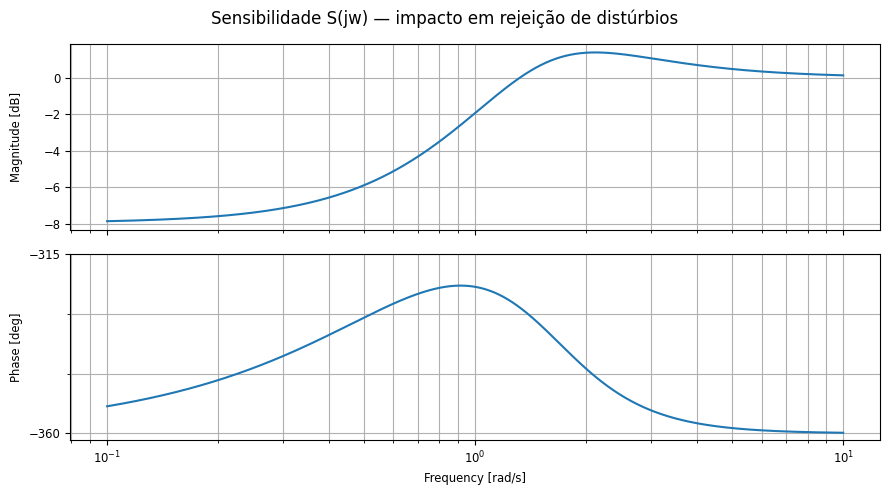

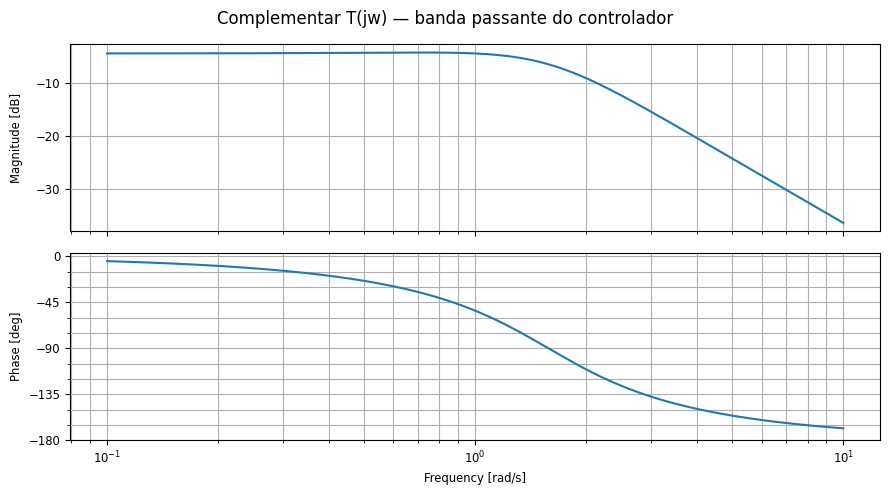

In [2]:
# Exemplo prático: planta de 2ª ordem com ganho e visualização de S e T
G = ctrl.tf([1], [1, 2, 1])   # planta exemplo
H = 1
L = G*1.5  # malha aberta ganhando 1.5 para exemplo

S = 1/(1+L)
T = L/(1+L)

# Bode de S e T
ctrl.bode_plot(S, dB=True)
plt.suptitle("Sensibilidade S(jw) — impacto em rejeição de distúrbios")
plt.show()

ctrl.bode_plot(T, dB=True)
plt.suptitle("Complementar T(jw) — banda passante do controlador")
plt.show()


### Estabilidade & Segurança Funcional (SIS, SIL)

- Em sistemas com funções de segurança (SIS), é obrigatório demonstrar estabilidade sob condições de falha e variações de parâmetros.
- Demonstrações analíticas (Routh-Hurwitz, Nyquist) e simulações são usadas para justificar níveis SIL.


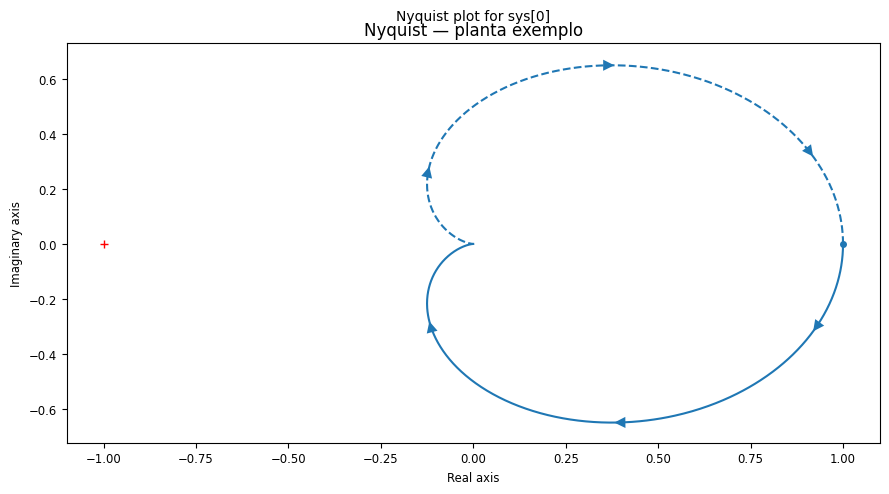

K=0.1: polos -> [-1.+0.3162j -1.-0.3162j]
K=1: polos -> [-1.+1.j -1.-1.j]
K=5: polos -> [-1.+2.2361j -1.-2.2361j]
K=10: polos -> [-1.+3.1623j -1.-3.1623j]


In [3]:
# Routh example: polinômio característico s^3 + 3s^2 + 3s + (1+K)
def routh_first_col(coeffs):
    # simplified Routh first-column changes (use earlier snippet if needed)
    import numpy as np
    table, _ = [], []
    # here we'll use roots to check stability (prático para relatório)
    roots = np.roots(coeffs)
    return roots

# Aplica Nyquist para G
ctrl.nyquist_plot(G)
plt.title("Nyquist — planta exemplo")
plt.grid(); plt.show()

# Teste simples de estabilidade por raízes do polinômio de malha fechada
Ks = [0.1, 1, 5, 10]
for K in Ks:
    CL = ctrl.feedback(K*G, 1)
    poles = ctrl.poles(CL)
    print(f"K={K}: polos ->", np.round(poles,4))


### Lugar das Raízes e uso em Digital Twin

- O LGR fornece trajetórias de polos para varreduras de parâmetros (K, atraso, massa).
- Em um Digital Twin, varre-se K e condições de processo virtual para detectar risco de instabilidade antes da ação em planta real.


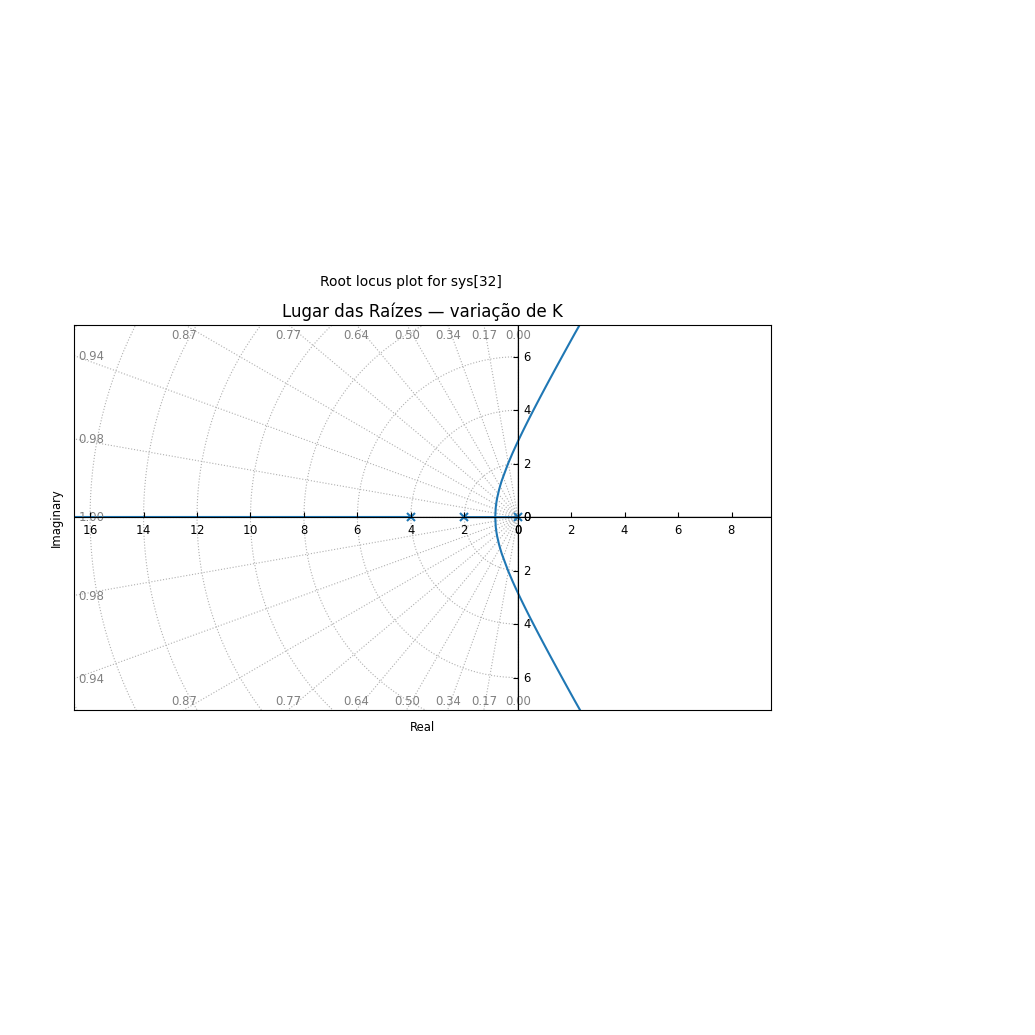

In [4]:
# Exemplo de LGR com anotações: varre ganho K e marca região segura (amortecimento ζ>0.5)
G_base = ctrl.tf([1], [1, 6, 8, 0])   # planta de exemplo (3ª ordem)
plt.figure()
ctrl.root_locus(G_base, grid=True)
plt.title("Lugar das Raízes — variação de K")
plt.show()

# Demonstração: calcular K que produz polos com ζ >= 0.5 (aprox.)
# (avançado: verificar interseção com linhas de amortecimento)


### Atrasos de transporte e impacto da rede (5G, WirelessHART)

- Atrasos introduzidos pela rede devem ser modelados (Padé) e testados na malha.  
- Se latência > margem de fase, controlador local deve ser redesenhado ou rede alterada.


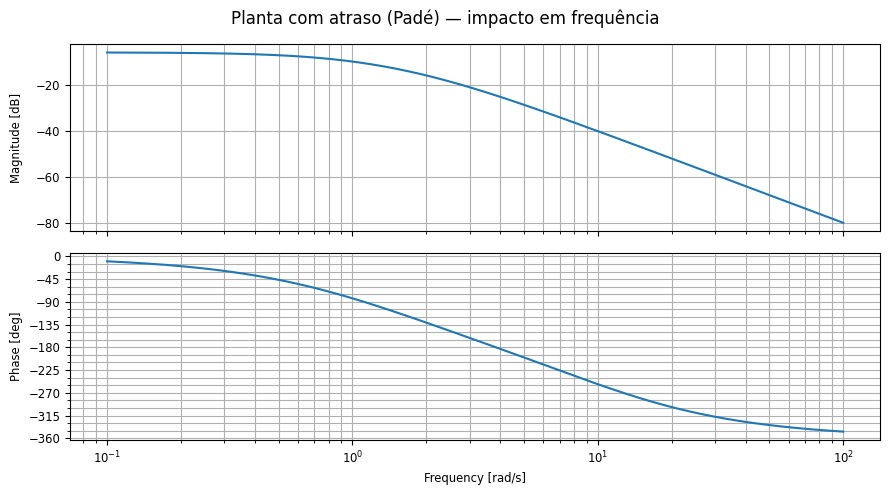

gm(dB): 24.719346998158386 pm(deg): inf


In [5]:
# Exemplo: planta simples com atraso modelado por Padé (1ª ordem) e análise de margem
Gp = ctrl.tf([1], [1, 3, 2])   # planta contínua
# Aproximação de Padé de atraso Tdelay
Tdelay = 0.2
num_pade, den_pade = ctrl.pade(Tdelay, 1)
G_with_delay = Gp * ctrl.tf(num_pade, den_pade)

ctrl.bode_plot(G_with_delay, dB=True)
plt.suptitle("Planta com atraso (Padé) — impacto em frequência")
plt.show()

gm, pm, wg, wp = ctrl.margin(G_with_delay)
print("gm(dB):", 20*np.log10(gm), "pm(deg):", pm)


### Integração TI↔TO e PIMS

- PIMS (OSISoft PI, Aspen IP21) armazena séries temporais (y(t), u(t), alarms).  
- Esses dados alimentam modelos do Digital Twin e rotinas de RTO/APC.  
- Requisito prático: garantir que o controlador não crie dados espúrios que contaminem modelos (ex.: saturação/anti-windup).


In [6]:
# Simula sinais (setpoint, saída, ruído) e exporta como JSON (exemplo para PI)
t = np.linspace(0, 50, 501)
# resposta da planta simples a degrau
t,y = ctrl.step_response(G, t)
setpoint = np.ones_like(t)*1.0
noise = 0.02*np.random.randn(len(t))
measured = y + noise

data = {"time": t.tolist(), "setpoint": setpoint.tolist(), "measured": measured.tolist()}
# converte para JSON (exemplo de payload que seria enviado via MQTT/OPC-UA)
payload = json.dumps(data)[:500]  # mostra trecho para evitar poluição
print("Exemplo de payload (trecho):", payload)


Exemplo de payload (trecho): {"time": [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005,


### Síntese teórica

- Controle clássico é base para todas as camadas superiores de Indústria 4.0.  
- Projetos robustos (margens, sensibilidade, testes de atraso) garantem confiabilidade e alimentam modelos de otimização.  
- No próximo notebook aplicamos estes conceitos: digital twin simples, APC simplificado, Monte-Carlo de latência, e simulação de envio de dados para PIMS/IIoT.


## Frequência de Amostragem, Aliasing e Efeito no Espectro

Para sistemas digitais, é fundamental analisar o espectro do sinal original e da versão amostrada.  
Nesta célula mostramos:
- Espectro do sinal contínuo
- Espectro do sinal amostrado
- Efeito do aliasing quando T é alto demais


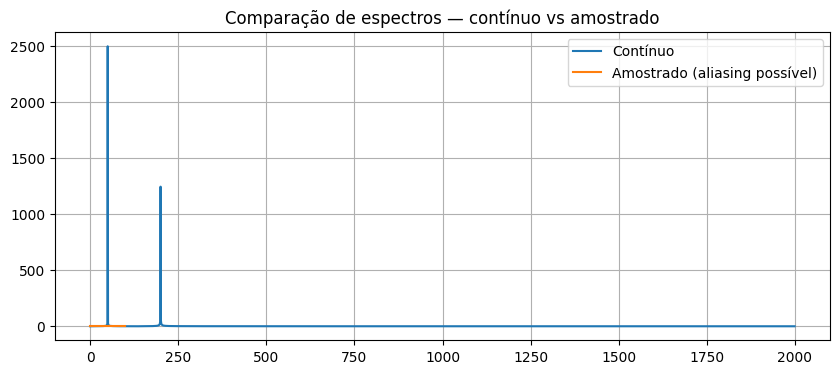

In [7]:
from scipy.fft import fft, fftfreq

# sinal contínuo
fs_cont = 5000  # alta frequência para aproximar contínuo
t = np.linspace(0, 1, fs_cont)
x = np.sin(2*np.pi*50*t) + 0.5*np.sin(2*np.pi*200*t)

# amostragem digital
T = 0.01  # 100 Hz
fs = 1/T
n = np.arange(0,1,T)
x_s = np.sin(2*np.pi*50*n) + 0.5*np.sin(2*np.pi*200*n)

# FFT
X_cont = np.abs(fft(x))[:2000]
X_s = np.abs(fft(x_s))

plt.figure(figsize=(10,4))
plt.plot(X_cont, label="Contínuo")
plt.plot(X_s, label="Amostrado (aliasing possível)")
plt.title("Comparação de espectros — contínuo vs amostrado")
plt.grid(); plt.legend()
plt.show()


## Variação de T e deslocamento dos polos no plano-z

Quanto maior o período de amostragem T, mais “longe” os polos se movem dentro do círculo unitário.

A seguir, comparamos os polos para vários valores de T.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

plt.rcParams['figure.figsize'] = (8,5)

# Definir planta contínua usada no exemplo
Gs = ctrl.tf([1], [1, 2, 0])
print("Planta definida:", Gs)


Planta definida: <TransferFunction>: sys[44]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      1
  ---------
  s^2 + 2 s


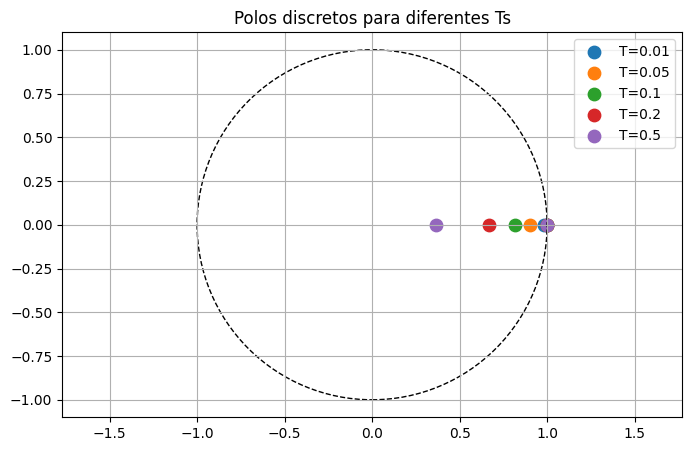

In [10]:
Ts = [0.01, 0.05, 0.1, 0.2, 0.5]
plt.figure()

for T in Ts:
    Gz_temp = ctrl.sample_system(Gs, T)
    p = ctrl.poles(Gz_temp)
    plt.scatter(np.real(p), np.imag(p), s=80, label=f"T={T}")

circle = plt.Circle((0,0),1,fill=False,linestyle="--")
plt.gca().add_patch(circle)
plt.title("Polos discretos para diferentes Ts")
plt.grid(); plt.legend(); plt.axis("equal")
plt.show()


## Comparação da resposta ao degrau para diferentes períodos de amostragem

Quanto maior T:
- pior a aproximação do sistema contínuo
- mais lenta a resposta
- maior o erro de regime e overshoot progressivo


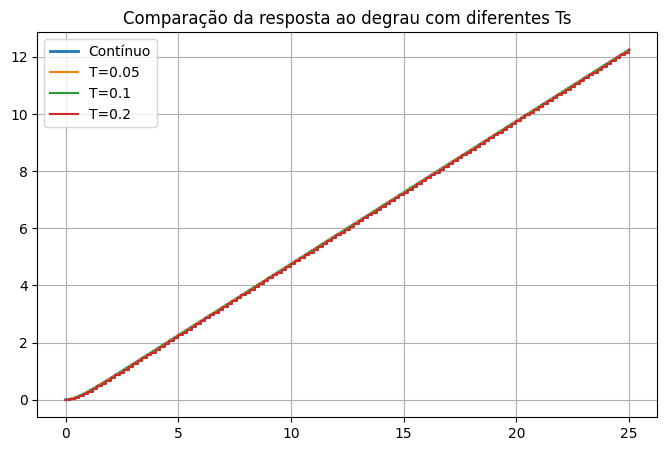

In [12]:
Ts = [0.05, 0.1, 0.2]
t_cont, y_cont = ctrl.step_response(Gs)

plt.figure()

plt.plot(t_cont, y_cont, label="Contínuo", linewidth=2)

for T in Ts:
    Gz_temp = ctrl.sample_system(Gs, T)
    t, y = ctrl.step_response(Gz_temp)
    plt.step(t, y, where="post", label=f"T={T}")

plt.title("Comparação da resposta ao degrau com diferentes Ts")
plt.grid(); plt.legend()
plt.show()


## LGR Digital (varredura densa de K)

Aqui mostramos uma varredura fina nos valores de K para observar o deslocamento suave dos polos.


In [14]:
!pip install control --quiet

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

plt.rcParams['figure.figsize'] = (8,5)

# Planta contínua
Gs = ctrl.tf([1], [1, 2, 0])

# Período de amostragem
T = 0.1

# Planta discreta equivalente
Gz = ctrl.sample_system(Gs, T)

print("Planta contínua:", Gs)
print("Planta discreta:", Gz)


Planta contínua: <TransferFunction>: sys[56]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      1
  ---------
  s^2 + 2 s
Planta discreta: <TransferFunction>: sys[56]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.1

  0.004683 z + 0.004381
  ----------------------
  z^2 - 1.819 z + 0.8187


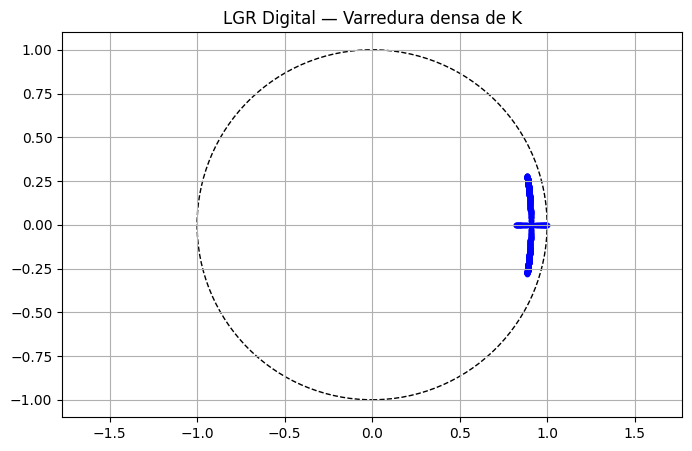

In [15]:
Ks = np.linspace(0, 10, 200)
plt.figure()

circle = plt.Circle((0,0),1,fill=False,linestyle="--")
plt.gca().add_patch(circle)

for K in Ks:
    CL = ctrl.feedback(K*Gz, 1)
    poles = ctrl.poles(CL)
    plt.scatter(np.real(poles), np.imag(poles), s=10, color="blue")

plt.title("LGR Digital — Varredura densa de K")
plt.grid(); plt.axis("equal")
plt.show()
